# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Построим модель для определения стоимости. 

**Основные шаги**

- Загрузим и прочитаем данные
- Обработаем данные: заполним пропущенные значения, обработаем аномалии в столбцах, удалим неинформативные признаки
- Подготовим выборки для обучения моделей: произведем разбивку данных на выборку, произведем кодирование, масштабируем данные.
- Обучим несколько моделей: обычную линейную регрессию, LightGBM, CatBoost, попробуем разные гиперпараметры.
- Проанализируем время обучения, время предсказания и качество моделей (метрика RMSE).
- Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

### Чтение данных

In [6]:
df = pd.read_csv('/datasets/autos.csv')

In [7]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Приведем названия колонк к `snake_case`

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [9]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [10]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Ознакомимся с данных 

In [11]:
df.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
number_of_pictures     int64
postal_code            int64
last_seen             object
dtype: object

In [12]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])

In [13]:
pd.DatetimeIndex(df['date_crawled']).year.value_counts(dropna=False)

2016    354369
Name: date_crawled, dtype: int64

Можем заметить, что все объявления были выбраны за 2016 год

**Признаки**
- `date_crawled` — дата скачивания анкеты из базы
- `vehicle_type` — тип автомобильного кузова
- `registration_year` — год регистрации автомобиля
- `gearbox` — тип коробки передач
- `power` — мощность (л. с.)
- `model` — модель автомобиля
- `kilometer` — пробег (км)
- `registration_month` — месяц регистрации автомобиля
- `fuel_type` — тип топлива
- `brand` — марка автомобиля
- `repaired` — была машина в ремонте или нет
- `date_created` — дата создания анкеты
- `number_of_pictures` — количество фотографий автомобиля
- `postal_code` — почтовый индекс владельца анкеты (пользователя)
- `last_seen` — дата последней активности пользователя


**Целевой признак**
- `price` — цена (евро)

Датасет состоит из 16 колонок и 354369 строк, 9 колонок имеют тип данных `object`, остальные 7 `int64`.

### Изучение данных

Проверим наличие дубликатов

In [14]:
df[df.duplicated() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Найдено 4 дубликата. Удалим их

In [15]:
df = df.drop_duplicates()
len(df)

354365

Избавимся от неинформативных столбцов

In [16]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1) 

In [17]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Проверим количество пропусков

In [18]:
df.isna().mean().sort_values(ascending=False)

repaired             0.200793
vehicle_type         0.105795
fuel_type            0.092828
gearbox              0.055968
model                0.055607
price                0.000000
registration_year    0.000000
power                0.000000
kilometer            0.000000
brand                0.000000
dtype: float64

In [19]:
unknown = ['repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model']

In [20]:
df[unknown] = df[unknown].fillna('unknown')

- **price** - цена

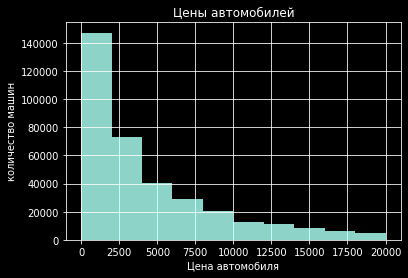

In [21]:
df['price'].hist().set(title='Цены автомобилей', xlabel = 'Цена автомобиля', ylabel='количество машин');

In [22]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Гистограмма выглядит реалистично, дешевые автомобили значительно превышают дорогие. Однако существуют нереалистично низкие значения цены.

Отбросим значения ниже пятого процентиля.

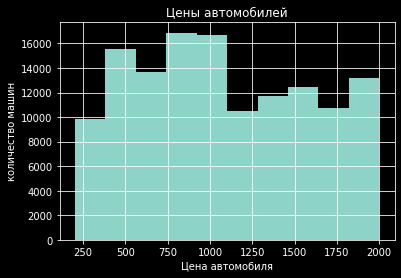

In [23]:
q = df['price'].quantile(0.05)
df = df[df['price'] > q]
(df[df['price'].between(0, 2000)]['price'].hist()
 .set(title='Цены автомобилей', xlabel = 'Цена автомобиля', ylabel='количество машин'));

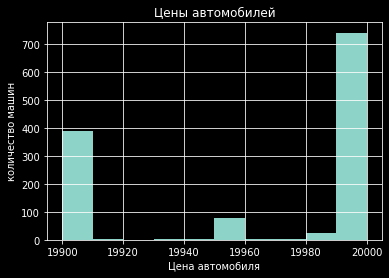

In [24]:
df[df['price'].between(19900, 20000)]['price'].hist().set(title='Цены автомобилей', xlabel = 'Цена автомобиля', ylabel='количество машин');

Можно заметить выброс в виде приблизительно 700 наблюдений, который находится в диапозоне цен от 19980 до 2000. Избавимся от этих наблюдений.

In [25]:
df = df[df['price'] < 19980]

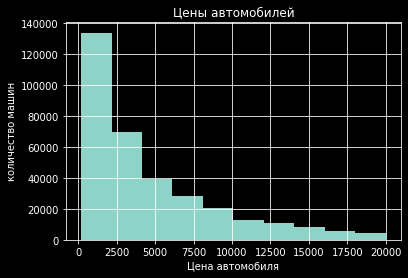

In [26]:
df['price'].hist().set(title='Цены автомобилей', xlabel = 'Цена автомобиля', ylabel='количество машин');

После удаления выброса, мы наблюдаем более реалистичную картину.

In [27]:
len(df)

334151

- **registration_year** - год регистрации автомобиля

Ознакомимся с таблицей

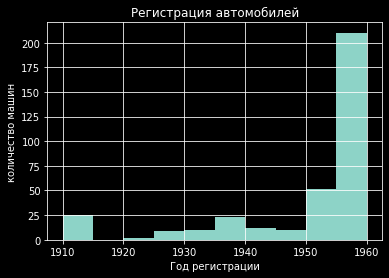

In [28]:
(df[df['registration_year'].between(1900, 1960)]['registration_year'].hist()
 .set(title='Регистрация автомобилей', xlabel = 'Год регистрации', ylabel='количество машин'));

Мы видим, что выброс существует в диапозоне до 1920 года, также основной массив наблюдений начинается с 1950 года. Отфильтруем датасет, оставив наблюдения с 1950 года

In [29]:
df = df[df['registration_year'] > 1950]

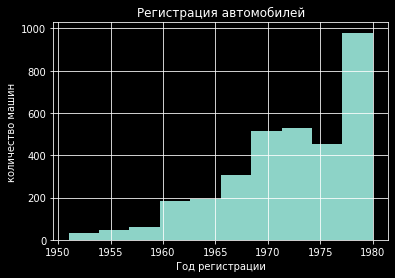

In [30]:
(df[df['registration_year'].between(1900, 1980)]['registration_year'].hist()
 .set(title='Регистрация автомобилей', xlabel = 'Год регистрации', ylabel='количество машин'));

Гистограмма представляет реалистичную картину 

Удалим строки, год регистрации автомобиля в которых, превышает 2016

In [31]:
df = df[df['registration_year'] <= 2016]

In [32]:
len(df)

320443

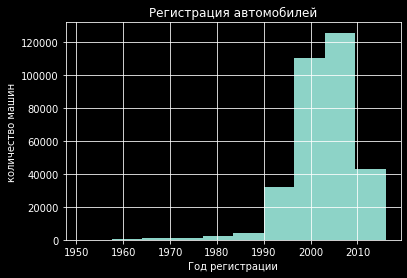

In [33]:
df['registration_year'].hist().set(title='Регистрация автомобилей', xlabel = 'Год регистрации', ylabel='количество машин');

**power** - мощность (л. с.)

Избавимся от выбросов

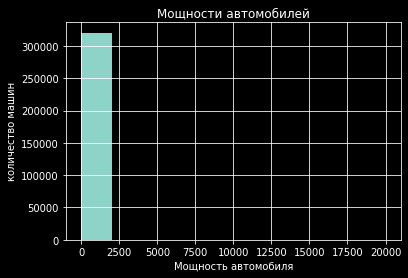

In [34]:
df['power'].hist().set(title='Мощности автомобилей', xlabel='Мощность автомобиля', ylabel='количество машин');

In [35]:
df = df[df['power'] < 2500]

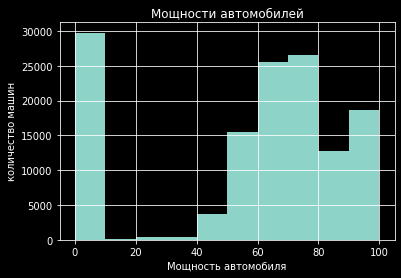

In [36]:
(df[df['power'].between(0, 100)]['power'].hist()
 .set(title='Мощности автомобилей', xlabel='Мощность автомобиля', ylabel='количество машин'));

In [37]:
df = df[df['power'] > 40]

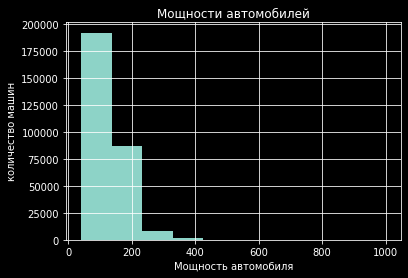

In [38]:
(df[df['power'].between(40, 1000)]['power'].hist()
 .set(title='Мощности автомобилей', xlabel='Мощность автомобиля', ylabel='количество машин'));

In [39]:
df = df[df['power'] < 600]

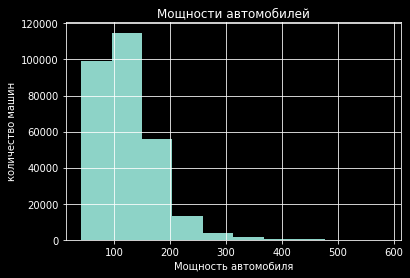

In [40]:
df['power'].hist().set(title='Мощности автомобилей', xlabel='Мощность автомобиля', ylabel='количество машин');

In [41]:
len(df)

289103

**kilometer** - пробег (км)

Проанализируем переменную на выбросы

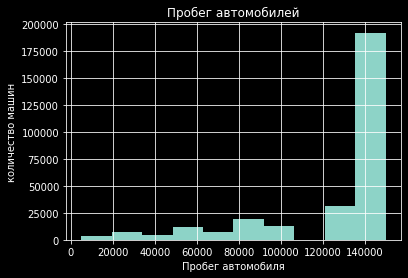

In [42]:
df['kilometer'].hist().set(title='Пробег автомобилей', xlabel='Пробег автомобиля', ylabel='количество машин');

Здесь все корректно

**brand** - марка автомобиля

Проверим дубликаты, пропуски

In [43]:
df['brand'].value_counts(dropna=False)

volkswagen        62628
bmw               31918
opel              31336
mercedes_benz     27104
audi              25343
ford              19885
renault           13417
peugeot            9250
fiat               7141
seat               5701
skoda              4908
mazda              4638
smart              4411
citroen            4094
toyota             3999
nissan             3915
hyundai            3075
mini               2948
volvo              2787
mitsubishi         2417
honda              2340
kia                2069
alfa_romeo         1946
suzuki             1892
sonstige_autos     1557
chevrolet          1449
chrysler           1142
dacia               798
subaru              619
porsche             608
daihatsu            575
jeep                572
saab                465
land_rover          459
jaguar              426
daewoo              390
lancia              364
rover               346
lada                157
trabant              14
Name: brand, dtype: int64

In [44]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2016,auto,150,159,150000,unknown,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


- Пропуски

In [45]:
df.isna().mean().sort_values(ascending=False)

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
dtype: float64

In [46]:
354369 - len(df)

65266

In [47]:
round(81393 / 3543.69, 2)

22.97

Мы избавились от неинформативных столбцов, а также убрали найденные выбросы. Пропуски мы заполнили значением `no_info`. В процессе предобработки мы избавились от 60912 наблюдений, что составляет 22,97 % от первоначальной выборки.

## Обучение моделей

### Подготовим выборки

- **Разобьем датасет на выборки**

In [48]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [49]:
cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [50]:
X = df.drop('price', axis=1)
y = df['price']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345)

- **Кодирование**

In [52]:
encoder = OrdinalEncoder() 
X_train_code = X_train.copy()
X_test_code = X_test.copy()

In [53]:
X_test

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
295113,sedan,2005,auto,231,3er,125000,petrol,bmw,no
92156,suv,2012,auto,140,kuga,50000,gasoline,ford,no
212040,suv,2003,manual,105,unknown,150000,gasoline,mazda,no
111353,sedan,1999,auto,170,5er,150000,petrol,bmw,no
27988,small,1997,manual,60,corsa,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...
284931,convertible,2001,auto,147,astra,150000,petrol,opel,no
92856,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
135076,wagon,2006,manual,140,passat,150000,gasoline,volkswagen,no
7441,wagon,1999,manual,90,golf,150000,gasoline,volkswagen,unknown


In [54]:
X_train_code[cat] = encoder.fit_transform(X_train_code[cat])
X_train_code

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
96302,5.0,1995,1.0,75,116.0,150000,6.0,38.0,0.0
211417,8.0,1999,1.0,82,42.0,5000,2.0,24.0,0.0
212150,5.0,2001,1.0,60,128.0,125000,6.0,10.0,1.0
199692,5.0,1997,1.0,60,83.0,150000,6.0,24.0,0.0
291656,4.0,2004,1.0,116,11.0,125000,6.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
194709,5.0,2006,1.0,65,172.0,100000,6.0,15.0,0.0
58815,0.0,1999,0.0,110,36.0,150000,2.0,30.0,0.0
105841,1.0,2011,1.0,69,13.0,30000,6.0,9.0,0.0
94694,2.0,1998,1.0,193,11.0,150000,6.0,2.0,0.0


In [55]:
X_test_code[cat] = encoder.transform(X_test[cat])
X_test_code

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
295113,4.0,2005,0.0,231,11.0,125000,6.0,2.0,0.0
92156,6.0,2012,0.0,140,135.0,50000,2.0,10.0,0.0
212040,6.0,2003,1.0,105,227.0,150000,2.0,19.0,0.0
111353,4.0,1999,0.0,170,15.0,150000,6.0,2.0,0.0
27988,5.0,1997,1.0,60,83.0,150000,6.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...
284931,1.0,2001,0.0,147,42.0,150000,6.0,24.0,0.0
92856,4.0,1995,1.0,113,95.0,150000,2.0,20.0,0.0
135076,8.0,2006,1.0,140,170.0,150000,2.0,38.0,0.0
7441,8.0,1999,1.0,90,116.0,150000,2.0,38.0,1.0


- **Масштабирование**

В переменную numeric сохраним список всех численных признаков.

In [56]:
numeric = ['registration_year', 'power', 'kilometer']

In [57]:
scaler = StandardScaler()
scaler.fit(X_train_code[numeric])

StandardScaler()

In [58]:
X_train_code[numeric] = scaler.transform(X_train_code[numeric])
X_test_code[numeric] = scaler.transform(X_test_code[numeric])

In [59]:
X_train_code

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
96302,5.0,-1.258995,1.0,-0.874666,116.0,0.589283,6.0,38.0,0.0
211417,8.0,-0.626075,1.0,-0.743113,42.0,-3.387140,2.0,24.0,0.0
212150,5.0,-0.309614,1.0,-1.156565,128.0,-0.096307,6.0,10.0,1.0
199692,5.0,-0.942535,1.0,-1.156565,83.0,0.589283,6.0,24.0,0.0
291656,4.0,0.165076,1.0,-0.104142,11.0,-0.096307,6.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
194709,5.0,0.481536,1.0,-1.062599,172.0,-0.781897,6.0,15.0,0.0
58815,0.0,-0.626075,0.0,-0.216901,36.0,0.589283,2.0,30.0,0.0
105841,1.0,1.272687,1.0,-0.987425,13.0,-2.701550,6.0,9.0,0.0
94694,2.0,-0.784305,1.0,1.342940,11.0,0.589283,6.0,2.0,0.0


### Обучение модели

- **Линейная регрессия**

In [285]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [286]:
df_ohe

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [287]:
X_ohe = df_ohe.drop('price', axis=1)
y_ohe = df_ohe['price']

In [288]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, random_state=12345)

In [289]:
scaler_ohe = StandardScaler()
scaler_ohe.fit(X_train_ohe[numeric])

StandardScaler()

In [290]:
X_train_ohe[numeric] = scaler_ohe.transform(X_train_ohe[numeric])
X_test_ohe[numeric] = scaler_ohe.transform(X_test_ohe[numeric])

/tmp/ipykernel_31/3626899151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_ohe[numeric] = scaler_ohe.transform(X_train_ohe[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/3626899151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [291]:
X_train_ohe

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
96302,-1.258995,-0.874666,0.589283,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
211417,-0.626075,-0.743113,-3.387140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212150,-0.309614,-1.156565,-0.096307,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
199692,-0.942535,-1.156565,0.589283,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
291656,0.165076,-0.104142,-0.096307,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194709,0.481536,-1.062599,-0.781897,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58815,-0.626075,-0.216901,0.589283,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105841,1.272687,-0.987425,-2.701550,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94694,-0.784305,1.342940,0.589283,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [294]:
model_regres = LinearRegression()

In [295]:
%%time
model_regres.fit(X_train_ohe, y_train_ohe)

CPU times: user 13.6 s, sys: 5.13 s, total: 18.8 s
Wall time: 18.7 s


LinearRegression()

In [296]:
%%time
predicted = model_regres.predict(X_train_ohe) 

CPU times: user 177 ms, sys: 175 ms, total: 352 ms
Wall time: 307 ms


RMSE

In [310]:
scores = cross_val_score(model_regres, X_train_ohe, y_train_ohe, cv=5, scoring='neg_root_mean_squared_error')
final_score = np.mean(scores) * -1

In [311]:
final_score

2527.638310147237

- **LightGBM**

In [313]:
model_lgbm = LGBMRegressor(random_state=12345)

In [314]:
parameters = {
    'max_depth' : [2, 5, 10],
    'num_leaves' : [50, 60]
}

In [315]:
gs_gbm = GridSearchCV(model_lgbm,parameters, cv=3, scoring='neg_root_mean_squared_error', verbose=10, n_jobs=-1)

neg_root_mean_squared_error

In [316]:
gs_gbm.fit(X_train_code, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_depth=2, num_leaves=50..................................
[CV 1/3; 1/6] END ................max_depth=2, num_leaves=50; total time=  44.8s
[CV 2/3; 1/6] START max_depth=2, num_leaves=50..................................
[CV 2/3; 1/6] END ................max_depth=2, num_leaves=50; total time=  40.1s
[CV 3/3; 1/6] START max_depth=2, num_leaves=50..................................
[CV 3/3; 1/6] END ................max_depth=2, num_leaves=50; total time=  51.0s
[CV 1/3; 2/6] START max_depth=2, num_leaves=60..................................
[CV 1/3; 2/6] END ................max_depth=2, num_leaves=60; total time=  44.6s
[CV 2/3; 2/6] START max_depth=2, num_leaves=60..................................
[CV 2/3; 2/6] END ................max_depth=2, num_leaves=60; total time=  51.0s
[CV 3/3; 2/6] START max_depth=2, num_leaves=60..................................
[CV 3/3; 2/6] END ................max_depth=2, nu

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10], 'num_leaves': [50, 60]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [317]:
gs_gbm.best_params_

{'max_depth': 10, 'num_leaves': 60}

In [318]:
model_lgbm = LGBMRegressor(max_depth=10, num_leaves=60)

In [319]:
%%time
model_lgbm.fit(X_train_code, y_train)

CPU times: user 6.17 s, sys: 0 ns, total: 6.17 s
Wall time: 6.18 s


LGBMRegressor(max_depth=10, num_leaves=60)

In [321]:
%%time
predicted_train = model_lgbm.predict(X_train_code) 

CPU times: user 1.9 s, sys: 0 ns, total: 1.9 s
Wall time: 1.89 s


In [322]:
(-1 * gs_gbm.best_score_)

1609.229194645305

- **CatBoost**

In [60]:
model_cat = CatBoostRegressor(random_seed=12345, cat_features=cat)

In [64]:
parameters_cat = {
    'iterations': [300, 750],
    'depth': [2, 6, 10]
}

In [65]:
cat_gbm =  GridSearchCV(model_cat,parameters_cat, cv=3, scoring='neg_root_mean_squared_error',verbose=10, n_jobs=-1)

In [66]:
cat_gbm.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START depth=2, iterations=300.....................................


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.239091
0:	learn: 4045.1082569	total: 69.7ms	remaining: 20.8s
1:	learn: 3680.6916626	total: 139ms	remaining: 20.8s
2:	learn: 3416.8481413	total: 198ms	remaining: 19.6s
3:	learn: 3200.4482896	total: 260ms	remaining: 19.2s
4:	learn: 3037.8112798	total: 312ms	remaining: 18.4s
5:	learn: 2919.3794977	total: 369ms	remaining: 18.1s
6:	learn: 2796.4842545	total: 421ms	remaining: 17.6s
7:	learn: 2684.2571253	total: 481ms	remaining: 17.6s
8:	learn: 2613.7817443	total: 537ms	remaining: 17.4s
9:	learn: 2545.7236584	total: 584ms	remaining: 16.9s
10:	learn: 2496.5540118	total: 633ms	remaining: 16.6s
11:	learn: 2444.6769005	total: 672ms	remaining: 16.1s
12:	learn: 2405.6022360	total: 700ms	remaining: 15.4s
13:	learn: 2372.7854400	total: 748ms	remaining: 15.3s
14:	learn: 2343.3314429	total: 787ms	remaining: 15s
15:	learn: 2304.4429355	total: 843ms	remaining: 15s
16:	learn: 2269.3598945	total: 887ms	remaining: 14.8s
17:	learn: 2249.4926949	total: 936ms	remaining: 14.7s
18:	learn: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f9519a54760>,
             n_jobs=-1,
             param_grid={'depth': [2, 6, 10], 'iterations': [300, 750]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [67]:
cat_gbm.best_params_

{'depth': 10, 'iterations': 750}

In [68]:
model_cat = CatBoostRegressor(random_seed=12345, cat_features=cat, depth=10, iterations=750)

In [69]:
%%time
model_cat.fit(X_train, y_train)

Learning rate set to 0.121021
0:	learn: 4167.4417306	total: 721ms	remaining: 9m
1:	learn: 3820.5510887	total: 1.35s	remaining: 8m 24s
2:	learn: 3516.1965556	total: 2.11s	remaining: 8m 44s
3:	learn: 3256.1251333	total: 2.64s	remaining: 8m 11s
4:	learn: 3043.2564258	total: 3.18s	remaining: 7m 54s
5:	learn: 2847.6848825	total: 3.78s	remaining: 7m 49s
6:	learn: 2680.9171736	total: 4.3s	remaining: 7m 36s
7:	learn: 2539.4321100	total: 4.89s	remaining: 7m 33s
8:	learn: 2422.7906140	total: 5.49s	remaining: 7m 31s
9:	learn: 2323.7307064	total: 5.99s	remaining: 7m 23s
10:	learn: 2241.8005804	total: 6.52s	remaining: 7m 18s
11:	learn: 2167.9447305	total: 7.16s	remaining: 7m 20s
12:	learn: 2105.9047025	total: 7.75s	remaining: 7m 19s
13:	learn: 2053.6323958	total: 8.73s	remaining: 7m 39s
14:	learn: 2010.1234281	total: 9.39s	remaining: 7m 39s
15:	learn: 1968.3409821	total: 9.92s	remaining: 7m 35s
16:	learn: 1930.6227059	total: 10.4s	remaining: 7m 30s
17:	learn: 1899.1420363	total: 11s	remaining: 7m 2

In [70]:
%%time
predicted_train = model_cat.predict(X_train) 

CPU times: user 3.84 s, sys: 27.9 ms, total: 3.87 s
Wall time: 3.98 s


RMSE

In [71]:
(-1 * cat_gbm.best_score_)

1515.6722902923648

## Анализ моделей

Для оценки качества модели нами применяется метрика RMSE. Это метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже RMSE, тем лучше модель соответствует набору данных. Для получения данного значения мы использовали атрибут best_score_.  

- Линейная: регрессия: 2527.64
- LightGBM: 1609.23
- CatBoost: 1515.67

Время обучения моделей.
- Линейная: 18.7 s
- LightGBM: 6.18 s
- CatBoost: 8min 4s

Скорость предсказания:
- Линейная: 307 ms
- LightGBM: 1.89 s
- CatBoost: 3.98 s


Самая высокая скорость обучения и предсказания у линейно регрессии, при этом она имеет худший показатель метрики, который не соответствует необходимому условию. Из двух оставшихся моделей CatBoost имеет наилучший показатель метрики RMSE. Скорость предсказания достаточно высокая у обеих оставшихся моделей. Поскольку это два первостепенных критерия, сделаем выбор в пользу модели CatBoost.

In [72]:
%%time
model_cat = CatBoostRegressor(random_seed=12345, cat_features=cat, depth=10, iterations=750)
model_cat.fit(X_train, y_train)

Learning rate set to 0.121021
0:	learn: 4167.4417306	total: 706ms	remaining: 8m 49s
1:	learn: 3820.5510887	total: 1.33s	remaining: 8m 18s
2:	learn: 3516.1965556	total: 1.97s	remaining: 8m 10s
3:	learn: 3256.1251333	total: 2.51s	remaining: 7m 48s
4:	learn: 3043.2564258	total: 3.13s	remaining: 7m 45s
5:	learn: 2847.6848825	total: 3.77s	remaining: 7m 47s
6:	learn: 2680.9171736	total: 4.43s	remaining: 7m 50s
7:	learn: 2539.4321100	total: 5.14s	remaining: 7m 57s
8:	learn: 2422.7906140	total: 5.78s	remaining: 7m 56s
9:	learn: 2323.7307064	total: 6.27s	remaining: 7m 44s
10:	learn: 2241.8005804	total: 6.86s	remaining: 7m 40s
11:	learn: 2167.9447305	total: 7.45s	remaining: 7m 38s
12:	learn: 2105.9047025	total: 7.97s	remaining: 7m 31s
13:	learn: 2053.6323958	total: 8.56s	remaining: 7m 30s
14:	learn: 2010.1234281	total: 9.19s	remaining: 7m 30s
15:	learn: 1968.3409821	total: 9.74s	remaining: 7m 26s
16:	learn: 1930.6227059	total: 10.3s	remaining: 7m 22s
17:	learn: 1899.1420363	total: 10.8s	remainin

In [73]:
predicted_test = model_cat.predict(X_test)

In [74]:
#RMSE
round(sqrt(mean_squared_error(y_test, predicted_test)), 2)

1495.15

Показатель качества модели удовлетворяет необходимому условию

Также для сравнения качества итоговой модели сравним ее с качеством модели, которая предсказывала бы константу. В качестве константной модели будем использовать DummyRegressor.

In [75]:
dummy_regr = DummyRegressor(strategy="mean")

In [76]:
dummy_regr.fit(X_train, y_train)

DummyRegressor()

In [77]:
predict_constant = dummy_regr.predict(X_test)

In [78]:
round(sqrt(mean_squared_error(y_test, predict_constant)), 2)

4535.18

Качество модели значительно уступает CatBoost и не соответствует заявленному уровню качества.

В ходе работы мы строили модель, которая умеет определять цену автомобиля по имеющимся у нас данным о технических характеристиках, комплектации и ценах других автомобилей. Необходимо было оценить используемые модели на качество предсказания,
время обучения модели, время предсказания модели. Мы обучили несколько моделей: обычную линейную регрессию, LightGBM, CatBoost, попробовали разные гиперпараметры.

Проанализировав время обучения, время предсказания и качество моделей (метрика RMSE), мы отсекли линейную регрессию, так как данная модель не соответсвовала необходимому уровню качества. Опираясь на критерии заказчика, мы выбрали модель CatBoost, обладающую самым высоким качеством.